In [1]:
import os
from pathlib import Path

import numpy as np
import xarray as xr
import xesmf as xe

from oslofjord.regrid import (
    fill_diagonal_pairs,
    fill_secondary_diagonal_pairs,
    fill_surrounded_nans,
    replace_surrounded_values,
)

### The script prepares a bathymetry for FjordsSim to construct a grid.
This is a latitude - longitude grid with equal geographical coordinates spacing.
First, choose the required grid z face levels.
We use a ROMS grid file for the Oslofjord as a basis.

In [2]:
Z_FACES = np.array(
    [
        -450.0,
        -400.0,
        -350.0,
        -300.0,
        -250.0,
        -200.0,
        -150.0,
        -100.0,
        -75.0,
        -50.0,
        -25.0,
        -15.0,
        -10.0,
        -7.5,
        -5.0,
        -3.0,
        -2.0,
        -1.0,
        0.0,
    ]
)
INPUT_GRID = os.path.join(Path.home(), "FjordsSim_data", "oslofjord", "OF160_grid_v2.nc")
ds_in = xr.open_dataset(INPUT_GRID)

Original grid:

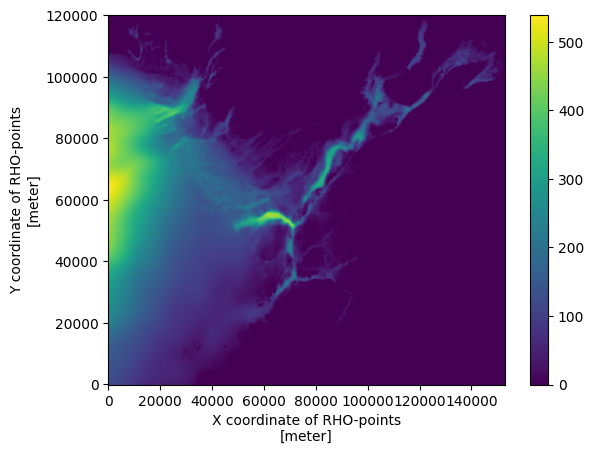

In [3]:
h = ds_in.h * ds_in.mask_rho
h.plot()

In [4]:
print(f"Lat min: {ds_in.lat_rho.values.min()}")
print(f"Lat max: {ds_in.lat_rho.values.max()}")
print(f"Lon min: {ds_in.lon_rho.values.min()}")
print(f"Lon max: {ds_in.lon_rho.values.max()}")

Lat min: 58.26531071946761
Lat max: 59.987599066742064
Lon min: 9.162863041847894
Lon max: 12.313798545701916


Chose the area, spacing and then regrid using XESMF

In [5]:
lat = np.linspace(59.0, 59.93, num=232)
lon = np.linspace(10.2, 11.02, num=105)

In [6]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], lat, {"units": "degrees_north"}),
        "lon": (["lon"], lon, {"units": "degrees_east"}),
    }
)
regridder = xe.Regridder(ds_in.rename({"lon_rho": "lon", "lat_rho": "lat"}), ds_out, "bilinear", unmapped_to_nan=True)
da_h_orig = regridder(h)

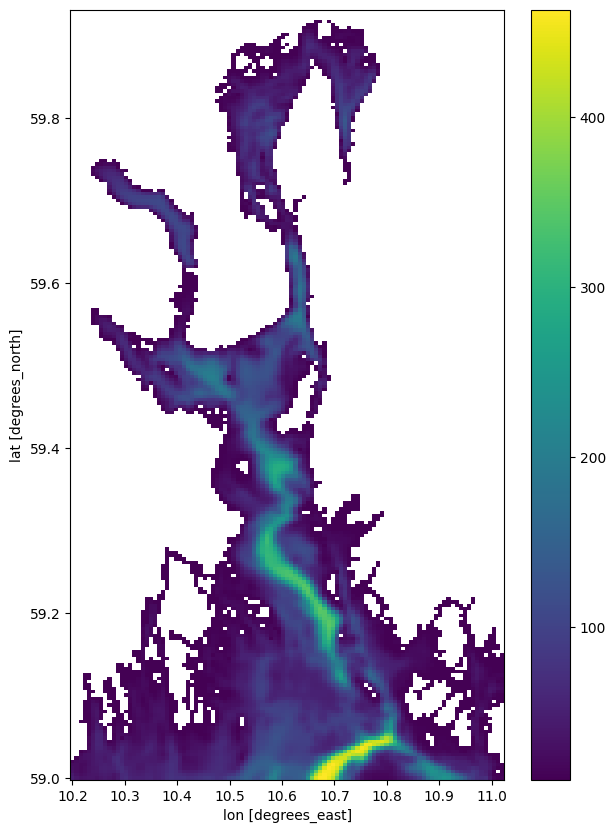

In [7]:
da_h = da_h_orig.where(da_h_orig > 0, np.nan)  # replace h=0 with nans
da_h = da_h.clip(min=10)  # and set a minimum depth to 10 meters
da_h.plot(figsize=(7, 10))

Fix grid

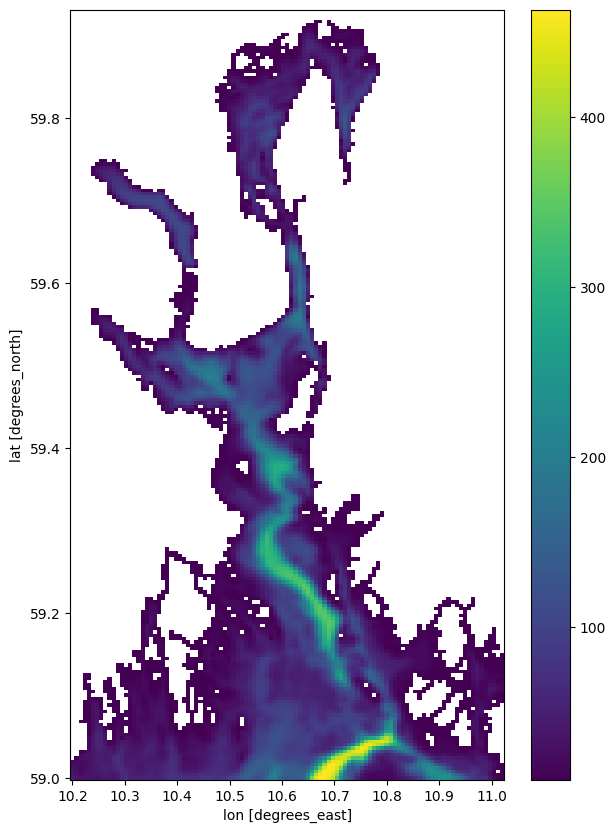

In [8]:
da_h.values = fill_secondary_diagonal_pairs(fill_diagonal_pairs(da_h.values))
da_h.plot(figsize=(7, 10))

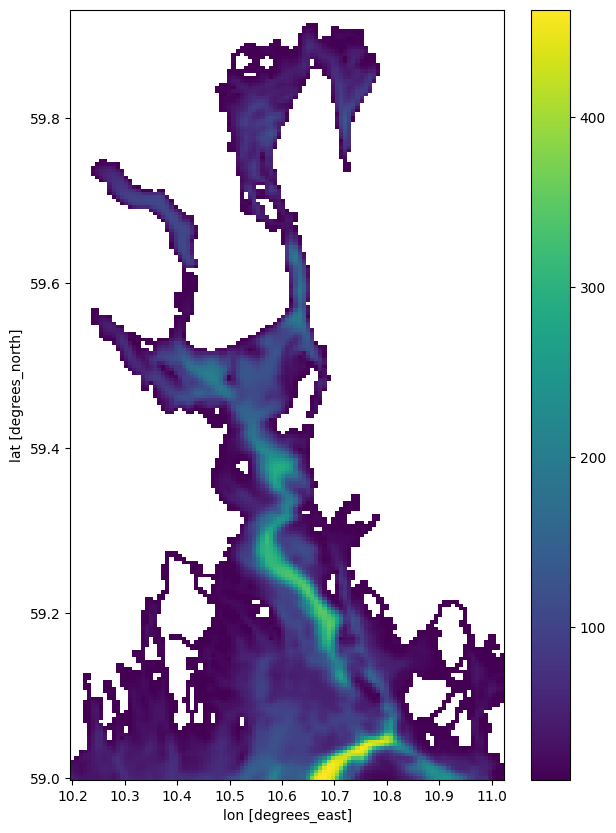

In [9]:
for _ in range(10):
    da_h.values = fill_surrounded_nans(replace_surrounded_values(da_h.values))  # run several times
da_h.plot(figsize=(7, 10))

Save grid

In [10]:
z_faces_da = xr.DataArray(
    Z_FACES,
    dims=("z_faces",),
    coords={"z_faces": Z_FACES},
    name="z_faces",
)

In [11]:
da_h.values = -1 * da_h.values
da_h = da_h.where(da_h < 0, 10)
dsout = xr.Dataset(
    {
        "h": da_h,
        "z_faces": z_faces_da,
    }
)

In [12]:
dsout

<xarray.Dataset> Size: 198kB
Dimensions:  (lat: 232, lon: 105, z_faces: 19)
Coordinates:
  * lat      (lat) float64 2kB 59.0 59.0 59.01 59.01 ... 59.92 59.92 59.93 59.93
  * lon      (lon) float64 840B 10.2 10.21 10.22 10.22 ... 11.0 11.0 11.01 11.02
  * z_faces  (z_faces) float64 152B -450.0 -400.0 -350.0 ... -2.0 -1.0 0.0
Data variables:
    h        (lat, lon) float64 195kB -47.99 -36.74 -32.31 ... 10.0 10.0 10.0

In [13]:
dsout.to_netcdf("/home/sia/FjordsSim_data/oslofjord/bathymetry_105to232.nc")